In [11]:
import importlib
import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from src.object_detection import get_bounding_boxes_dino
from src import bbox_utils
importlib.reload(bbox_utils)

# from src.hand_search import get_hand_bbox

<module 'src.bbox_utils' from '/home/be2r-lab-210134/Python/functional_grasp/Semantic_Object_Segmentation_for_Affordance_Labeling/src/bbox_utils.py'>

In [12]:
from src import hand_search
importlib.reload(hand_search)

<module 'src.hand_search' from '/home/be2r-lab-210134/Python/functional_grasp/Semantic_Object_Segmentation_for_Affordance_Labeling/src/hand_search.py'>

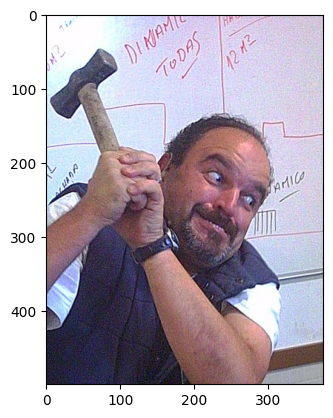

In [13]:
data_dir = Path("./data/hammer_1")
scene_image_path = data_dir/"scenes/hold_hammer_011129.jpg"
scene_image = cv2.imread(scene_image_path)
scene_image = cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB)
# cv2.imwrite("scene_image.jpg", scene_image)

plt.imshow(scene_image)

In [14]:
hand_bbox = np.round(hand_search.get_hand_bbox(scene_image, bboxes[0], vis=True))
hand_bbox

I0000 00:00:1745851286.304926   10738 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745851286.320146   18098 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
W0000 00:00:1745851286.378051   18090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745851286.411696   18089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


array([ 92, 193, 148, 301])

In [50]:
bboxes, scores = get_bounding_boxes_dino(scene_image, "weapon")

In [51]:
print(bboxes, scores)

[[  4.9502234  45.56927   134.24406   267.00726  ]] [0.40772042]


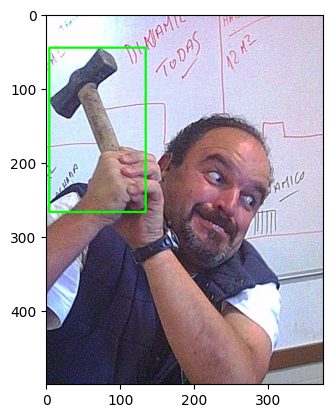

In [52]:
vis_scene_image  = scene_image.copy()
bbox_utils.add_bbox(vis_scene_image, np.asarray(bboxes[0],dtype='int32') , color=(0, 255, 0), thickness=2)

plt.imshow(vis_scene_image)

In [ ]:
from src.segmentation_utils import get_masks_sam

masks, scores = get_masks_sam(scene_image, list(bboxes[0]))
print(masks, scores)

In [ ]:
masks.shape

In [ ]:
mask = masks[0][1]
# Convert to RGB image
rgb_image = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Initialize as black

# Set 0 (background) → White
rgb_image[mask == 0] = [255, 255, 255]  

# Set 1 (object) → Gray
rgb_image[mask == 1] = [128, 128, 128]  

plt.imshow(rgb_image)
plt.axis('off')
# plt.imsave(data_dir/"mask.png", rgb_image)

In [ ]:
from PIL import Image

def resize_to_match_longer_side(img_src, img_target, bbox=None):
    """
    Resizes img_target so that its longer side matches img_src's longer side.
    Also rescales a bounding box if provided.

    Parameters:
    - img_src: PIL.Image (reference image)
    - img_target: PIL.Image (image to resize)
    - bbox: tuple (x1, y1, x2, y2) in original img_target coords

    Returns:
    - resized_img: PIL.Image (resized target image)
    - resized_bbox: tuple (x1, y1, x2, y2) in resized image coords (if bbox is given)
    """
    w1, h1 = img_src.size
    w2, h2 = img_target.size

    # Compute scale to match longer side
    scale = max(w1, h1) / max(w2, h2)
    new_size = (int(w2 * scale), int(h2 * scale))

    # Resize image
    resized_img = img_target.resize(new_size, Image.Resampling.LANCZOS)

    # Scale bounding box if provided
    resized_bbox = None
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        resized_bbox = (
            int(x1 * scale),
            int(y1 * scale),
            int(x2 * scale),
            int(y2 * scale)
        )

    return resized_img, resized_bbox

image1 = Image.open(data_dir/"render.png")
image2 = Image.open(data_dir/"mask.png")

In [ ]:
image2

In [ ]:
mask_rescaled, hand_bbox_rescaled = resize_to_match_longer_side(image1, image2, hand_bbox)
# mask_rescaled.save(data_dir/"mask_rescaled.png")

In [ ]:

def paint_bounding_box(image, bbox, color):
    """
    Paint all points inside the bounding box with the specified color.

    Parameters:
    - image: PIL.Image object.
    - bbox: Bounding box tuple (x1, y1, x2, y2) (top-left to bottom-right).
    - color: The color to paint inside the box (e.g., (255, 0, 0) for red).

    Returns:
    - painted_image: A new PIL.Image with the painted box.
    """
    # Create a copy of the image to avoid modifying the original
    painted_image = image.copy()
    draw = ImageDraw.Draw(painted_image)

    # Get the bounding box coordinates
    x1, y1, x2, y2 = bbox

    # Paint the area inside the bounding box with the specified color
    for x in range(x1, x2):
        for y in range(y1, y2):
            draw.point((x, y), fill=color)

    return painted_image

# Example usage:
# Open an image
image = mask_rescaled

# Define the bounding box (x1, y1, x2, y2)
bbox = hand_bbox_rescaled

# Define the color (e.g., red)
color = (255, 0, 0)

# Apply the painting function
painted_image = paint_bounding_box(image, bbox, color)

# Save the new image
painted_image.save("painted_image.png")

# Optionally, display it
painted_image.show()

In [ ]:
from src import feature_matching 
importlib.reload(feature_matching)
# import get_matching_transformation, bbox_to_corners, transform_corners
M = feature_matching.get_matching_transformation(image1, mask_rescaled, vis=True)
# H = np.load(data_dir/"homography_matrix.npy")
# M = np.load(data_dir/"affine_matrix.npy")
corners = feature_matching.bbox_to_corners(hand_bbox_rescaled)
# corners = np.array([[600,250],[900,250],[900,450],[600,450]])
# transformed_corners = feature_matching.transform_corners(corners, H)
transformed_corners = feature_matching.transform_corners_affine(corners, M)

transformed_corners


In [ ]:
import cv2

# Load the image
image = np.array(mask_rescaled)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Invert threshold: detect gray object on white background
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rotated bounding rectangles
for contour in contours:
    if cv2.contourArea(contour) > 500:  # Optional: Filter by area
        # Get the rotated bounding rectangle
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)  # Get the 4 points of the rectangle
        box = np.int0(box)  # Convert to integer points for drawing

        # Draw the rotated bounding box
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

# Show result
cv2.imshow('Rotated Bounding Rectangles', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Invert threshold: detect gray object on white background
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Combine all contours into one large set of points
all_points = np.concatenate(contours)  # Concatenate all points of the contours

# Get the rotated bounding rectangle for all contours
rect = cv2.minAreaRect(all_points)
box = cv2.boxPoints(rect)  # Get the 4 points of the rectangle
box = np.int0(box)  # Convert points to integer

# Draw the rotated bounding rectangle on the image
cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

# Show the result
cv2.imshow('Minimum Rotated Bounding Rectangle for All Objects', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
rect

In [ ]:
w2 = rect[1][0] / 2
h2 = rect[1][1]/ 2
points = np.array([
    [-w2, -h2],  # top-left
    [ w2, -h2],  # top-right
    [ w2,  h2],  # bottom-right
    [-w2,  h2],  # bottom-left
])
theta = np.deg2rad(rect[2])
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
rotated_points = np.dot(points, R.T)

In [ ]:
final_points = rotated_points + np.array([rect[0][0], rect[0][1]])
final_points = np.int0(final_points)
final_points

In [ ]:
box = cv2.boxPoints(rect) 
box

In [ ]:
def compute_homography(matched_pts_img1, matched_pts_img2):
    """
    Computes a homography matrix H that maps points from image2 to image1.
    """
    if len(matched_pts_img1) >= 4:
        H, mask = cv2.findHomography(matched_pts_img2, matched_pts_img1, cv2.RANSAC, 5.0)
        return H, mask
    else:
        raise ValueError("At least 4 point correspondences are required to compute homography.")
    

H, mask = compute_homography(feature_matching.bbox_to_corners(np.array([569, 394, 1357, 684])), final_points)

In [ ]:
transformed_corners = feature_matching.transform_corners(corners, H)

In [ ]:
feature_matching.bbox_to_corners(np.array([569, 394, 1357, 684]))

In [ ]:
box

In [ ]:
box

In [ ]:
box

In [ ]:
feature_matching.apply_homography(H,corners[1])

In [ ]:
corners = np.array([[600,250],[900,250],[900,450],[600,450]])
corners=np.round(corners).astype(int)
c = [(corner[0], corner[1]) for corner in corners]

In [ ]:
import cv2
image1 = Image.open(data_dir/"render.png")

In [ ]:
tc = [(int(corner[0]), int(corner[1])) for corner in transformed_corners]

In [ ]:
from PIL import ImageDraw
# image = Image.fromarray(object_image)
draw = ImageDraw.Draw(image1)
draw.polygon(tc, outline="green", width=2)
image1.show()

In [ ]:
from PIL import ImageDraw
# image = Image.fromarray(object_image)
draw = ImageDraw.Draw(mask_rescaled)
draw.polygon(c, outline="green", width=2)
mask_rescaled.show()

In [ ]:
def apply_homography(H, point):
    """
    Applies homography matrix H to a 2D point (x, y).
    Returns the transformed point in image1 coordinates.
    """
    point_hom = np.array([point[0], point[1], 1.0])
    transformed = H @ point_hom
    transformed /= transformed[2]  # Normalize by last coordinate
    return transformed[:2]

In [ ]:
apply_homography(H, corners[0])